In [2]:
%%capture
%pip install -r ../requirements.txt

In [3]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

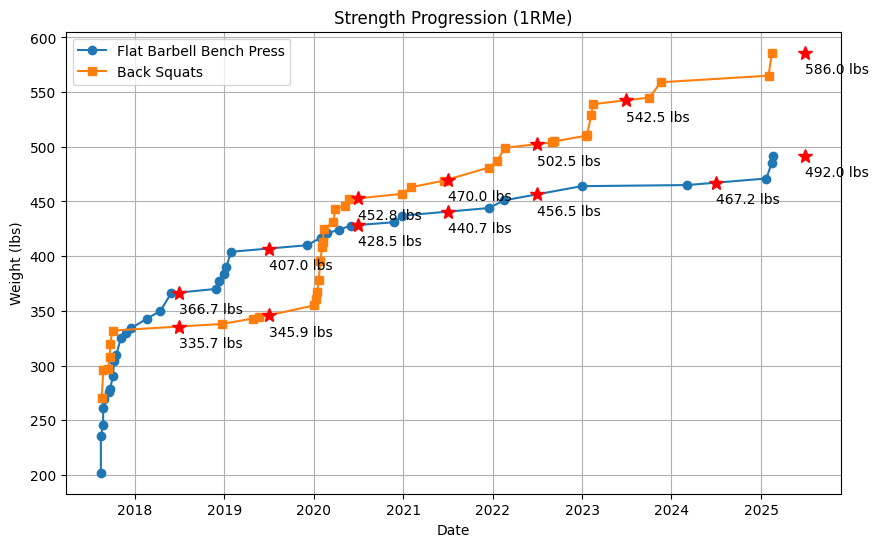

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect data for each exercise
exercises = ["Flat Barbell Bench Press", "Back Squats"]
exercise_data = {ex: [] for ex in exercises}

for workout in wld.workouts:
    for exercise in workout.exercises:
        key = exercise.displayName()
        if key in exercises:
            for set_data in exercise.sets:
                if set_data.weight is not None:  # Only include sets with weight data
                    exercise_data[key].append({
                        "date": workout.date,
                        "weight": set_data.oneRM
                    })

# Convert to DataFrames and get max progressions
max_dfs = {}
for exercise in exercises:
    # Convert to DataFrame and sort
    df = pd.DataFrame(exercise_data[exercise])
    if not df.empty:
        df = df.sort_values("date")

        # Get max progression
        running_max = 0
        max_data = []
        for _, row in df.iterrows():
            if row["weight"] > running_max:
                running_max = row["weight"]
                max_data.append({"date": row["date"], "weight": row["weight"]})

        max_dfs[exercise] = pd.DataFrame(max_data)

plt.figure(figsize=(10, 6))
markers = ["o", "s", "^"]
for exercise, marker in zip(exercises, markers):
    if exercise in max_dfs and not max_dfs[exercise].empty:
        df = max_dfs[exercise]

        # Plot all points
        plt.plot(df["date"], df["weight"], marker=marker, label=exercise)

        # Find and plot July 1st points
        years = df["date"].dt.year.unique()
        for year in years:
            july_date = pd.Timestamp(f"{year}-07-01")

            # Find points before and after July 1st
            before_july = df[df["date"] <= july_date]
            after_july = df[df["date"] > july_date]

            if not before_july.empty:
                last_before = before_july.iloc[-1]

                # If we have a point after July 1st, interpolate
                if not after_july.empty:
                    first_after = after_july.iloc[0]

                    # Linear interpolation
                    days_between = (first_after["date"] - last_before["date"]).days
                    days_to_july = (july_date - last_before["date"]).days
                    weight_diff = first_after["weight"] - last_before["weight"]
                    interpolated_weight = last_before["weight"] + (
                        weight_diff * days_to_july / days_between
                    )

                    plt.plot(
                        july_date,
                        interpolated_weight,
                        "r*",
                        markersize=10,
                    )
                    plt.annotate(
                        f"{interpolated_weight:.1f} lbs",
                        (july_date, interpolated_weight),
                        xytext=(0, -15),
                        textcoords="offset points",
                    )
                else:
                    # If no point after, use the last point before
                    plt.plot(
                        july_date,
                        last_before["weight"],
                        "r*",
                        markersize=10,
                    )
                    plt.annotate(
                        f'{last_before["weight"]:.1f} lbs',
                        (july_date, last_before["weight"]),
                        xytext=(0, -15),
                        textcoords="offset points",
                    )

plt.title("Strength Progression (1RMe)")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.grid(True)
plt.legend()
plt.show()

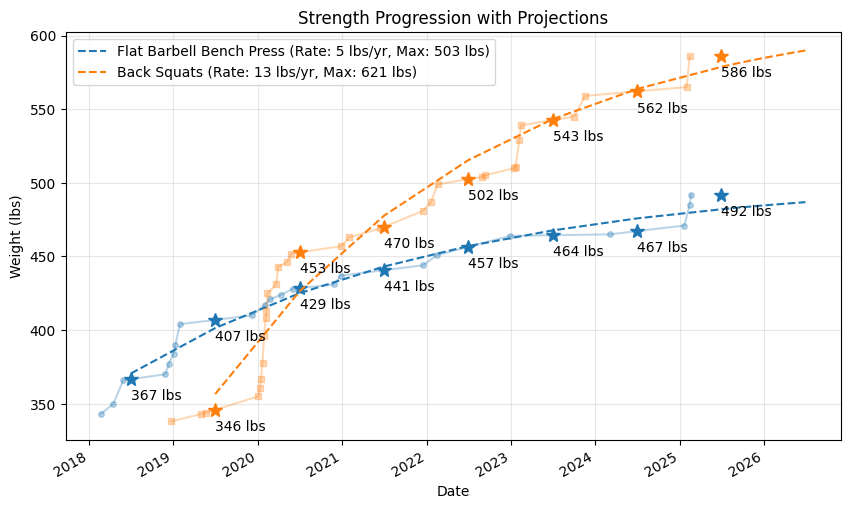


Current Progress Stats:
--------------------------------------------------
Flat Barbell Bench Press: 492 lbs
Back Squats: 586 lbs


In [5]:
from scipy.optimize import curve_fit
from matplotlib.dates import date2num, num2date
import numpy as np
from datetime import datetime, timedelta


def asymptotic_func(x, a, b, c):
    """Asymptotic function: a - b*exp(-c*x)
    a: asymptote (max value)
    b: total expected growth
    c: growth rate
    """
    return a - b * np.exp(-c * x)


plt.figure(figsize=(10, 6))
markers = ["o", "s", "^"]

for exercise, marker in zip(exercises, markers):
    if exercise in max_dfs and not max_dfs[exercise].empty:
        df = max_dfs[exercise]

        # Filter data from 2018 onwards
        df = df[df["date"].dt.year >= 2018]

        # Find July 1st points for ALL years between min and max date
        selected_points = []
        min_year = df["date"].dt.year.min()
        max_year = df["date"].dt.year.max()

        for year in range(min_year, max_year + 1):
            july_date = pd.Timestamp(f"{year}-07-01")

            # Find points before and after July 1st
            before_july = df[df["date"] <= july_date]
            after_july = df[df["date"] > july_date]

            if not before_july.empty:
                last_before = before_july.iloc[-1]

                # If we have a point after July 1st, interpolate
                if not after_july.empty:
                    first_after = after_july.iloc[0]

                    # Linear interpolation
                    days_between = (first_after["date"] - last_before["date"]).days
                    days_to_july = (july_date - last_before["date"]).days
                    weight_diff = first_after["weight"] - last_before["weight"]
                    interpolated_weight = last_before["weight"] + (
                        weight_diff * days_to_july / days_between
                    )

                    selected_points.append((july_date, interpolated_weight))
                else:
                    # If no point after, use the last point before
                    selected_points.append((july_date, last_before["weight"]))

        if len(selected_points) >= 2:  # Need at least 2 points for fitting
            selected_dates = [p[0] for p in selected_points]
            selected_weights = [p[1] for p in selected_points]

            # Convert dates to numbers for fitting
            date_nums = date2num(selected_dates)
            min_date_num = min(date_nums)
            normalized_dates = date_nums - min_date_num

            try:
                # Fit asymptotic function to July 1st points
                popt, _ = curve_fit(
                    asymptotic_func,
                    normalized_dates,
                    selected_weights,
                    p0=[
                        max(selected_weights) * 1.1,
                        max(selected_weights) * 0.5,
                        0.001,
                    ],
                    bounds=(
                        [max(selected_weights), 0, 0],
                        [max(selected_weights) * 1.5, max(selected_weights), 0.01],
                    ),
                )

                # Create future dates for projection (1 year out)
                future_dates = selected_dates + [
                    selected_dates[-1] + timedelta(days=x) for x in range(1, 365)
                ]
                future_date_nums = date2num(future_dates)
                normalized_future_dates = future_date_nums - min_date_num

                # Calculate trendline
                trendline = asymptotic_func(normalized_future_dates, *popt)

                # Calculate current rate of progress (lbs/year)
                def asymptotic_derivative(x, a, b, c):
                    return b * c * np.exp(-c * x)

                current_rate = asymptotic_derivative(normalized_dates[-1], *popt) * 365

                # Plot actual data points as small dots
                line = plt.plot(
                    df["date"],
                    df["weight"],
                    marker=marker,
                    markersize=4,
                    linestyle="-",
                    alpha=0.3,
                )[0]
                line_color = line.get_color()

                # Plot July 1st points as stars
                for date, weight in selected_points:
                    plt.plot(date, weight, marker="*", markersize=10, color=line_color)
                    plt.annotate(
                        f"{weight:.0f} lbs",
                        (date, weight),
                        xytext=(0, -15),
                        textcoords="offset points",
                    )

                # Plot projection
                plt.plot(
                    future_dates,
                    trendline,
                    "--",
                    color=line_color,
                    label=f"{exercise} (Rate: {current_rate:.0f} lbs/yr, Max: {popt[0]:.0f} lbs)",
                )

            except RuntimeError:
                print(f"Could not fit curve for {exercise}")
                continue

plt.title("Strength Progression with Projections")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Print current stats
print("\nCurrent Progress Stats:")
print("-" * 50)
for exercise in exercises:
    if exercise in max_dfs and not max_dfs[exercise].empty:
        df = max_dfs[exercise]
        current_weight = df["weight"].iloc[-1]
        print(f"{exercise}: {current_weight:.0f} lbs")

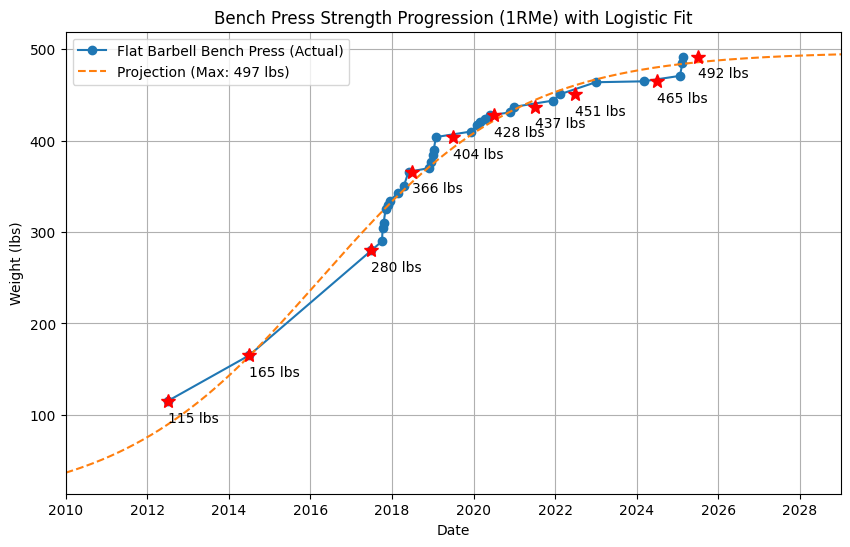

In [18]:
# --- Bench Only Analysis ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

bench_exercise = "Flat Barbell Bench Press"
bench_data = []
for workout in wld.workouts:
    for exercise in workout.exercises:
        if exercise.displayName() == bench_exercise:
            for set_data in exercise.sets:
                if set_data.weight is not None:
                    bench_data.append({"date": workout.date, "weight": set_data.oneRM})

# Add historical data points
historical_data = [
    {"date": pd.Timestamp("2012-07-01"), "weight": 115},
    {"date": pd.Timestamp("2014-07-01"), "weight": 165},
    {"date": pd.Timestamp("2017-07-01"), "weight": 280}
]
bench_data.extend(historical_data)

bench_df = pd.DataFrame(bench_data)
if not bench_df.empty:
    bench_df = bench_df.sort_values("date")
    running_max = 0
    max_data = []
    for _, row in bench_df.iterrows():
        if row["weight"] > running_max:
            running_max = row["weight"]
            max_data.append({"date": row["date"], "weight": row["weight"]})
    max_bench_df = pd.DataFrame(max_data)

    # Convert dates to numbers for curve fitting
    dates_numeric = (max_bench_df["date"] - max_bench_df["date"].min()).dt.total_seconds()
    weights = max_bench_df["weight"].values

    # Define logistic function
    def logistic(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))

    # Fit logistic curve
    p0 = [max(weights) * 1.2, 1e-8, np.mean(dates_numeric)]  # Initial parameter guesses
    popt, _ = curve_fit(logistic, dates_numeric, weights, p0=p0)

    # Generate points for smooth curve including past dates
    past_start = pd.Timestamp('2010-01-01')
    past_seconds = (past_start - max_bench_df["date"].min()).total_seconds()
    future_dates_numeric = np.linspace(past_seconds, max(dates_numeric) * 1.5, 1000)
    trendline = logistic(future_dates_numeric, *popt)

    plt.figure(figsize=(10, 6))
    # Plot actual data points
    plt.plot(
        max_bench_df["date"], max_bench_df["weight"], marker="o", label=f"{bench_exercise} (Actual)"
    )

    # Plot projection including past
    projection_dates = [max_bench_df["date"].min() + pd.Timedelta(seconds=float(x)) for x in future_dates_numeric]
    plt.plot(projection_dates, trendline, "--", label=f"Projection (Max: {popt[0]:.0f} lbs)")

    # Plot July 1st points
    years = max_bench_df["date"].dt.year.unique()
    for year in years:
        july_date = pd.Timestamp(f"{year}-07-01")
        before_july = max_bench_df[max_bench_df["date"] <= july_date]
        if not before_july.empty:
            last_before = before_july.iloc[-1]
            plt.plot(july_date, last_before["weight"], "r*", markersize=10)
            plt.annotate(
                f"{last_before['weight']:.0f} lbs",
                (july_date, last_before["weight"]),
                xytext=(0, -15),
                textcoords="offset points",
            )

    plt.title("Bench Press Strength Progression (1RMe) with Logistic Fit")
    plt.xlabel("Date")
    plt.ylabel("Weight (lbs)")
    plt.grid(True)
    plt.legend()

    # Set x-axis limits from 2010 to 2028
    plt.xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2028-12-31'))

    plt.show()